## TF tensor input model flavors with MLflow Generic Model

In [1]:
import numpy as np
import tensorflow as tf
import mlflow
import time
import json
from mlflow.models import infer_signature
print("TF Version :", tf.__version__)

TF Version : 2.19.0


In [2]:
mlflow_uri = "http://mlflow-server:8888"
mlflow.set_tracking_uri(mlflow_uri)
time.sleep(5)
#mlflow.set_experiment(mlflow_uri)
mlflow.set_experiment("test_new")

2025/06/06 13:22:47 INFO mlflow.tracking.fluent: Experiment with name 'test_new' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/165913490617322141', creation_time=1749216167076, experiment_id='165913490617322141', last_update_time=1749216167076, lifecycle_stage='active', name='test_new', tags={}>

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train) , (x_test,y_test) = mnist.load_data()
x_train,x_test =  x_train/255.0 , x_test/255.0

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


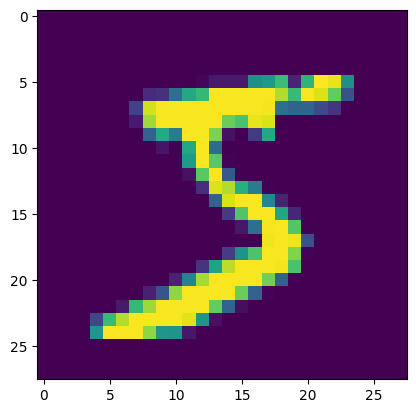

In [4]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

In [5]:
import json
class custom_tf_model(mlflow.pyfunc.PythonModel):
    def __init__(self,params):
        self.params = params
        self.tf_model = None
        self.config = None

    def load_context(self, context = None, config_path = None):
        if context:
            config_path = context.artifacts["config_path"]
            
        else:
            pass
        self.config = json.load(open(config_path))

    
    def fit(self,x_train,y_train):
        tf_model,eval_loss,eval_acc = self.train_model()
        self.tf_model = tf_model

    def predict(self, context, model_input):
        return self.tf_model.predict(model_input)
    

    def train_model(self,p_epoch=2, p_optimizer = "Adam", l1_noNode= 32, l1_activation="relu",l1_dropout= 0.2):
        loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(l1_noNode,activation=l1_activation),
            tf.keras.layers.Dropout(l1_dropout),
            tf.keras.layers.Dense(10)
        ])

        model.compile(optimizer = p_optimizer,loss= loss_func, metrics = ['accuracy'])

        model.fit(x_train,y_train,epochs = p_epoch)

        eval_loss, eval_acc = model.evaluate(x_test,y_test,verbose=2)


        print(f"eval_loss : {eval_loss} | eval_acc : {eval_acc}")

        return model,eval_loss,eval_acc
        




/usr/local/lib/python3.11/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [6]:
config_path = "data_tf.json"
params_ = {
    "epochs" : 5
}
custom_tf_obj = custom_tf_model(params_)
custom_tf_obj.load_context(config_path=config_path)
custom_tf_obj.fit(x_train=x_train,y_train=y_train)

/usr/local/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2


2025-06-06 13:23:02.064755: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step - accuracy: 0.7819 - loss: 0.7123
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step - accuracy: 0.9174 - loss: 0.2845
313/313 - 0s - 538us/step - accuracy: 0.9511 - loss: 0.1710
eval_loss : 0.17097847163677216 | eval_acc : 0.9510999917984009


2025-06-06 13:23:04.825442: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


In [7]:
from sys import version_info
conda_env_tf = {
    "channels": ["defaults"],
    "dependencies": [
        f"python={version_info.major}.{version_info.minor}.{version_info.micro}",
        "pip",
        {"pip": ["mlflow",
                 f"tensorflow=={tf.__version__}"]
        },
    ],
    "name": "tf_env"
}
conda_env_tf

{'channels': ['defaults'],
 'dependencies': ['python=3.11.13',
  'pip',
  {'pip': ['mlflow', 'tensorflow==2.19.0']}],
 'name': 'tf_env'}

In [8]:
predictions_tf = custom_tf_obj.predict(context=None,model_input=x_test)
print(predictions_tf.shape)
model_signature = infer_signature(x_test,predictions_tf)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
(10000, 10)


2025-06-06 13:23:13.252239: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


In [9]:
type(model_signature)
model_signature

inputs: 
  [Tensor('float64', (-1, 28, 28))]
outputs: 
  [Tensor('float32', (-1, 10))]
params: 
  None

In [10]:
artifacts_tf = {
    "config_path" : config_path
}
artifacts_tf

{'config_path': 'data_tf.json'}

In [11]:
conda_env_tf

{'channels': ['defaults'],
 'dependencies': ['python=3.11.13',
  'pip',
  {'pip': ['mlflow', 'tensorflow==2.19.0']}],
 'name': 'tf_env'}

In [12]:
with mlflow.start_run(run_name="generic_model3") as run2:
    mlflow.pyfunc.log_model(
        "custom_tf",
        python_model = custom_tf_obj,
        artifacts = artifacts_tf,
        conda_env = conda_env_tf,
        signature = model_signature,
        input_example = x_train[0:5]
    )

2025/06/06 13:23:23 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2025/06/06 13:23:23 INFO mlflow.pyfunc: Validating input example against model signature
/usr/local/lib/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
🏃 View run generic_model3 at: http://mlflow-server:8888/#/experiments/165913490617322141/runs/7ae71dbf0ec7437daf0522e57eaa7559
🧪 View experiment at: http://mlflow-server:8888/#/experiments/165913490617322141


In [13]:
import mlflow
logged_model = 'runs:/7ae71dbf0ec7437daf0522e57eaa7559/custom_tf'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)



In [14]:
# Predict on a Pandas DataFrame.
import pandas as pd
result = loaded_model.predict(x_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [15]:
result

array([[ -4.3607526 , -12.169812  ,  -0.9593032 ,   0.04697762,
         -7.2581353 ,  -4.6035733 , -17.074661  ,   7.08896   ,
         -4.298863  ,  -0.88948613],
       [  1.5582805 ,  -0.19012718,  10.094993  ,   4.4598694 ,
        -14.894306  ,   0.76271135,  -2.8592718 ,  -6.6693234 ,
         -2.71962   , -11.529357  ],
       [ -5.622249  ,   5.6166353 ,  -0.6124428 ,  -1.6558986 ,
         -3.0043004 ,  -2.5107572 ,  -2.1523046 ,  -0.22085863,
         -0.64369136,  -2.299418  ],
       [  8.106625  ,  -7.100047  ,  -3.177436  ,  -2.902764  ,
         -8.801589  ,  -0.54839677,  -4.2099323 ,  -2.2629633 ,
         -7.9226713 ,  -2.2337658 ],
       [ -3.488242  ,  -5.6656594 ,  -1.8066968 ,  -4.3125725 ,
          4.317549  ,  -2.8421092 ,  -1.7892858 ,  -0.63355094,
         -2.9365609 ,   1.5057465 ],
       [ -7.3449364 ,   7.016824  ,  -1.8200865 ,  -1.8779823 ,
         -3.504801  ,  -3.7030678 ,  -4.030673  ,   0.3406265 ,
          0.11002479,  -2.6213813 ],
       [ -